In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [ ]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(index))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



s_norm, mu, std = AbstractDataset.normalize(S)


s_train, p_train, s_test, p_test = split(s_norm, P, ind)

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "/home/jcartus/Repos/SCFInitialGuess/cc2ai/ethen/"
postfix = "_ethen_6-31g**"
dim = 48
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
#F = np.load(join(data_path, "F" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

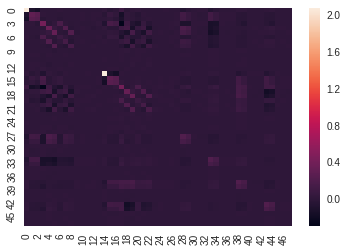

In [3]:
import seaborn as sns

sns.heatmap(P[0].reshape(dim, dim))

# Pure blocks

i will now set all other elements zero

## Utilities

In [4]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS["6-31g**"][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

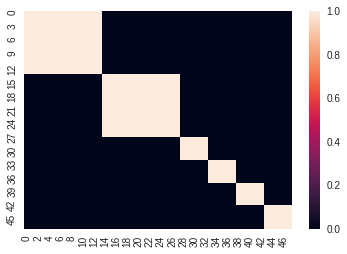

In [5]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [8]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0.0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test))).astype("float64")

In [9]:
p_pure[0]

array([[ 2.06134667e+00, -1.01256491e-01, -1.49066059e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.01256491e-01,  2.90046735e-01,  2.42009018e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.49066059e-01,  2.42009018e-01,  2.11606618e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.24173285e-04, -3.07488546e-04, -1.33777817e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.07488546e-04,  4.49948837e-04,  1.42889848e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33777817e-04,  1.42889848e-04,  1.70813576e-04]])

In [10]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

N_ELECTRONS = 30

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)


## Pure Block Analysis 

In [11]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 12:09:58: Iteration calculation: 0
[ ] 2018-10-05 12:09:59: Iteration calculation: 1
[ ] 2018-10-05 12:09:59: Iteration calculation: 2
[ ] 2018-10-05 12:09:59: Iteration calculation: 3
[ ] 2018-10-05 12:10:00: Iteration calculation: 4
[ ] 2018-10-05 12:10:00: Iteration calculation: 5
[ ] 2018-10-05 12:10:01: Iteration calculation: 6
[ ] 2018-10-05 12:10:01: Iteration calculation: 7
[ ] 2018-10-05 12:10:02: Iteration calculation: 8
[ ] 2018-10-05 12:10:02: Iteration calculation: 9
[ ] 2018-10-05 12:10:03: Iteration calculation: 10
[ ] 2018-10-05 12:10:03: Iteration calculation: 11
[ ] 2018-10-05 12:10:03: Iteration calculation: 12
[ ] 2018-10-05 12:10:04: Iteration calculation: 13
[ ] 2018-10-05 12:10:04: Iteration calculation: 14
[ ] 2018-10-05 12:10:04: Iteration calculation: 15
[ ] 2018-10-05 12:10:04: Iteration calculation: 16
[ ] 2018-10-05 12:10:05: Iteration calculation: 17
[ ] 2018-10-05 12:10:05: Iteration calculation: 18
[ ] 2018-10-05 12:10:05: Iteration calcul

# Embedding the Blocks In Classical Guesses

In [12]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [14]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x):
    p = x[1].copy()
    p[mask] = x[0].copy()[mask]
    return p

p_embedded_sad = np.array(list(map(embedd, zip(p_test, p_sad))))
p_embedded_gwh = np.array(list(map(embedd, zip(p_test, p_gwh))))

## SAD

In [16]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 12:15:45: Iteration calculation: 0
[ ] 2018-10-05 12:15:46: Iteration calculation: 1
[ ] 2018-10-05 12:15:46: Iteration calculation: 2
[ ] 2018-10-05 12:15:47: Iteration calculation: 3
[ ] 2018-10-05 12:15:47: Iteration calculation: 4
[ ] 2018-10-05 12:15:47: Iteration calculation: 5
[ ] 2018-10-05 12:15:48: Iteration calculation: 6
[ ] 2018-10-05 12:15:48: Iteration calculation: 7
[ ] 2018-10-05 12:15:49: Iteration calculation: 8
[ ] 2018-10-05 12:15:49: Iteration calculation: 9
[ ] 2018-10-05 12:15:49: Iteration calculation: 10
[ ] 2018-10-05 12:15:50: Iteration calculation: 11
[ ] 2018-10-05 12:15:50: Iteration calculation: 12
[ ] 2018-10-05 12:15:50: Iteration calculation: 13
[ ] 2018-10-05 12:15:51: Iteration calculation: 14
[ ] 2018-10-05 12:15:51: Iteration calculation: 15
[ ] 2018-10-05 12:15:51: Iteration calculation: 16
[ ] 2018-10-05 12:15:51: Iteration calculation: 17
[ ] 2018-10-05 12:15:52: Iteration calculation: 18
[ ] 2018-10-05 12:15:52: Iteration calcul

## GWH

In [18]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 12:18:52: Iteration calculation: 0
[ ] 2018-10-05 12:18:53: Iteration calculation: 1
[ ] 2018-10-05 12:18:53: Iteration calculation: 2
[ ] 2018-10-05 12:18:54: Iteration calculation: 3
[ ] 2018-10-05 12:18:54: Iteration calculation: 4
[ ] 2018-10-05 12:18:54: Iteration calculation: 5
[ ] 2018-10-05 12:18:55: Iteration calculation: 6
[ ] 2018-10-05 12:18:55: Iteration calculation: 7
[ ] 2018-10-05 12:18:55: Iteration calculation: 8
[ ] 2018-10-05 12:18:56: Iteration calculation: 9
[ ] 2018-10-05 12:18:56: Iteration calculation: 10
[ ] 2018-10-05 12:18:56: Iteration calculation: 11
[ ] 2018-10-05 12:18:57: Iteration calculation: 12
[ ] 2018-10-05 12:18:57: Iteration calculation: 13
[ ] 2018-10-05 12:18:57: Iteration calculation: 14
[ ] 2018-10-05 12:18:58: Iteration calculation: 15
[ ] 2018-10-05 12:18:58: Iteration calculation: 16
[ ] 2018-10-05 12:18:58: Iteration calculation: 17
[ ] 2018-10-05 12:18:58: Iteration calculation: 18
[ ] 2018-10-05 12:18:59: Iteration calcul

# McWheeny

In [19]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
s_test_batch = make_matrix_batch(S[ind:], dim)

In [20]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from SCFInitialGuess.utilities.dataset import make_matrix_batch

#del p_embedded_sad
#del p_sad
#del p_gwh
#del P
#del dataset
#del molecules
#del p_pure
#del s_train
#del p_train

f = lambda x: multi_mc_wheeny(x[0], x[1], 20)

p_embedded_gwh_mcw5 = np.array(list(map(f, zip(p_embedded_gwh, s_test_batch))))

In [22]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-05 12:22:31: Iteration calculation: 0
[ ] 2018-10-05 12:22:32: Iteration calculation: 1
[ ] 2018-10-05 12:22:32: Iteration calculation: 2
[ ] 2018-10-05 12:22:32: Iteration calculation: 3
[ ] 2018-10-05 12:22:32: Iteration calculation: 4
[ ] 2018-10-05 12:22:33: Iteration calculation: 5
[ ] 2018-10-05 12:22:33: Iteration calculation: 6
[ ] 2018-10-05 12:22:33: Iteration calculation: 7
[ ] 2018-10-05 12:22:33: Iteration calculation: 8
[ ] 2018-10-05 12:22:34: Iteration calculation: 9
[ ] 2018-10-05 12:22:34: Iteration calculation: 10
[ ] 2018-10-05 12:22:34: Iteration calculation: 11
[ ] 2018-10-05 12:22:35: Iteration calculation: 12
[ ] 2018-10-05 12:22:35: Iteration calculation: 13
[ ] 2018-10-05 12:22:35: Iteration calculation: 14
[ ] 2018-10-05 12:22:35: Iteration calculation: 15
[ ] 2018-10-05 12:22:36: Iteration calculation: 16
[ ] 2018-10-05 12:22:36: Iteration calculation: 17
[ ] 2018-10-05 12:22:36: Iteration calculation: 18
[ ] 2018-10-05 12:22:36: Iteration calcul